# Contents

* [Data](#data)
* [PCA](#pca)
* [k-Means Tuning](#k_means)
  * [Silhouette Analysis](#s_score)
  * [Davies-Bouldin Analysis](#db_score)
  * [Calinski-Harabasz Analysis](#ch_score)

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import pandas as pd
import pprint

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

from project_code.clustering import plot_tsne_clusters

random_state = 1
np.random.seed(random_state)

## Load and Prepare Data <a class="anchor" id="data"></a>

Data is loaded from a previous save.
The data has already been standardized.

The data will be randomly split into 5 sets, 
which will be used to assess consistency of clustering performance.

In [4]:
# read in the data without imputions that are distribution dependent
data =  pd.read_csv('../_data/std_df.csv')

In [16]:
# get the indicies and split into cross val sets (20%)
idx_values = data.index.values.copy()
np.random.shuffle(idx_values)
cross_val_splits = np.array_split(idx_values, 5)

# PCA Decomposition <a class="anchor" id="pca"></a>


Since clustering scales poorly as the size of data inceases,
we will first attempt for reduce the number of features first with PCA.
PCA is performed on each split of the dataset.

## Variance Explained

The following plots show that approximate 50-75 components of the PCA should be sufficient to explain the majority of the data variance.
We find that on average 50 components are sufficent to explain 95% of the variance.
Substantially more components are necessary to explain 99% percent of the variance,
approximate 87 components on average.
The increase in expained variance increases slowly with increase in components after 50.
We will continue the analysis using 50 components.

| Variance Explained | N Components* |
|:------------------:|:------------:|
| 80%                | 25 |
| 85%                | 29 | 
| 90%                | 36 |
| 95%                | 50 |
| 99%                | 87 |

\*Mean over splits fo data

Note: 200 components were used in the PCA decomposition because approximately 200 was suggested by Minka’s MLE method for guessing the size of the dimension.

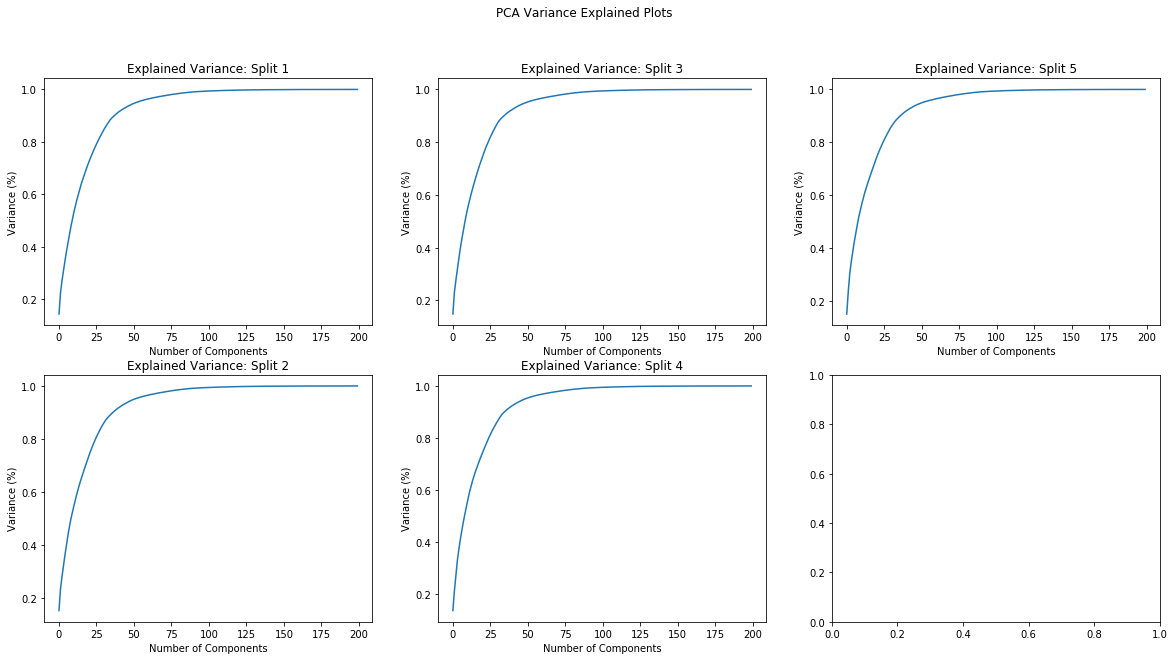

In [58]:
pca_list = list()
pca_comp = list()

for split in cross_val_splits:
    pca = PCA(n_components = 200,
             random_state = random_state)
    pca.fit(data.iloc[split])
    pca_comp.append(pca.transform(data.iloc[split]))
    pca_list.append(pca)
    
fig, ax = plt.subplots(2,3, figsize = (20,10));
fig.suptitle('PCA Variance Explained Plots');

for i, p in enumerate(pca_list):
    if i % 2 == 0:
        ax[0, i // 2].plot(
            np.cumsum(p.explained_variance_ratio_)
        )
        ax[0, i // 2].set_ylabel('Variance (%)')
        ax[0, i // 2].set_xlabel('Number of Components')
        ax[0, i // 2].set_title('Explained Variance: Split ' + str(i + 1))
    else:
        ax[1, (i - 1) // 2].plot(
            np.cumsum(p.explained_variance_ratio_)
        )
        ax[1, (i - 1) // 2].set_ylabel('Variance (%)')
        ax[1, (i - 1) // 2].set_xlabel('Number of Components')
        ax[1, (i - 1) // 2].set_title('Explained Variance: Split ' + str(i + 1))

In [ ]:
n_comp = np.empty(len(pca_list))
n_comp_exp = list()
amounts = [0.8, 0.85, 0.9, 0.95, 0.99]

for explained_var in amounts:

    print(f"\n\nNumber of components necessary to achieve {explained_var * 100}% explained variance\n")

    for i, p in enumerate(pca_list):
        n_comp[i] = p.explained_variance_ratio_[np.cumsum(p.explained_variance_ratio_) < explained_var].size
        print(f"PCA on split {i}:", n_comp[i])
    print(f"\nThe mean number of components is {np.round(n_comp.mean(), 0)} (rounded)")

    # get the number of PCA components to use
    n_components = np.int(np.round(n_comp.mean(), 0))
    n_comp_exp.append(n_components)
    
# set n_components for the remaining analysis
n_components = 50

plt.plot(n_comp_exp, amounts, marker = 'o')
plt.title('Variance Explained vs Number of Components')

## Tuning k-Means Clustering <a class="anchor" id="k_means"></a>

Assess whether k-means appears to be able to create valid clusters from the principle components.

### Silhouette Analysis <a class="anchor" id="s_score"></a>

A silhouette analysis of k-means clustering with k from 2 to 200 shows low confidence in k-means ability to produce valid clusterings.
The maximum mean silhouette score is at k = 2.
The score drops by about 50% when k is increased from 2 to 3.
The mean silhouette drops dramatically with increase in k, essentially flattening at a score of approximately 0.05 at k = 6.

### Davies-Bouldin Analysis <a class="anchor" id="db_score"></a>

This score measures the average similarity measure of each cluster with its most similar cluster.
A lower score is considered better.
The first minimum is a k = 2, which is unsurprising considering the behavior of silhouette.
However, the second minimum is at k = 36.
A plot of the [2-D t-SNE shows that k = 36](#k_36) appears to capture some interesting clusters.
This minimum is also "near" the second peak in silhouette (at [k = 30](#k_30)).

### Calinski-Harabasz Analysis <a class="anchor" id="ch_score"></a>

This score measures the ratio of within-cluster dispersion to between-cluster dispersion.
As expected it decreases as k increases like the inertia.


In [121]:
means = list()
results = dict()
k_values = [x for x in range(2, 200, 1)]

for k in k_values:
    km = KMeans(n_clusters = k)
    sil = dict()
    inert = dict()
    results[k] = {
        'sil':sil,
        'inert':inert          
        }
    for i, component_set in enumerate(pca_comp):
        km.fit(component_set[:, : n_components])
        results[k]['inert'][i] = km.inertia_
        results[k]['sil'][i] = silhouette_score(component_set[:, : n_components], km.labels_)

In [122]:
sil_means = np.empty(len(results.keys()))
inert_means = np.empty(len(results.keys()))

for i, k in enumerate(results.keys()):
    inert_means[i] = np.mean([*results[k]['inert'].values()])
    sil_means[i] = np.mean([*results[k]['sil'].values()])

In [143]:
# get the kmeans labels for k values
labels = list()

for k in k_values:
    labels.append(
        KMeans(
            n_clusters = k,
            random_state = random_state
    ).fit(component_set[:, : n_components]).labels_)

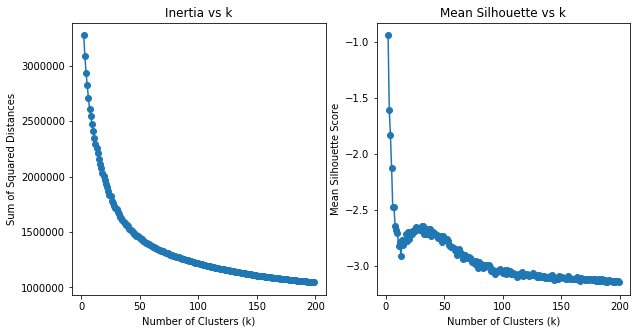

In [185]:
fig, ax = plt.subplots(1, 2, figsize = (10,5))
ax[0].plot(k_values, inert_means, marker = 'o')
ax[0].set_title('Inertia vs k')
ax[0].set_xlabel('Number of Clusters (k)')
ax[0].set_ylabel('Sum of Squared Distances')
ax[1].plot(k_values, np.log(sil_means), marker = 'o')
ax[1].set_title('Mean Silhouette vs k');
ax[1].set_ylabel('Mean Silhouette Score')
ax[1].set_xlabel('Number of Clusters (k)');

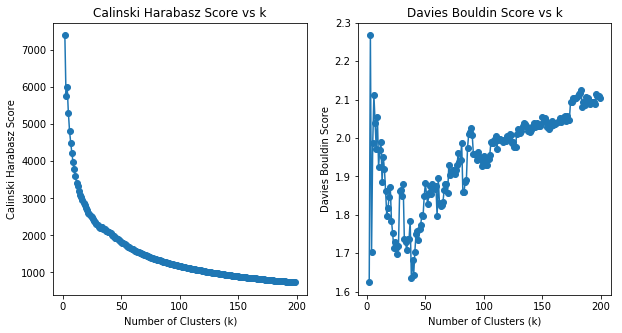

In [145]:
ch_scores = list()
db_scores = list()
for lab in labels: 
    ch_scores.append(
        calinski_harabasz_score(
            component_set[:, : n_components],
            lab
        )
    )
    db_scores.append(
        davies_bouldin_score(
            component_set[:, : n_components],
            lab
        )
    )

fig, ax = plt.subplots(1, 2, figsize = (10,5))
ax[0].plot(k_values, ch_scores, marker = 'o')
ax[0].set_title('Calinski Harabasz Score vs k')
ax[0].set_xlabel('Number of Clusters (k)')
ax[0].set_ylabel('Calinski Harabasz Score')
ax[1].plot(k_values, db_scores, marker = 'o')
ax[1].set_title('Davies Bouldin Score vs k');
ax[1].set_ylabel('Davies Bouldin Score')
ax[1].set_xlabel('Number of Clusters (k)');

In [180]:
np.where(np.array(db_scores) < 1.64)

(array([ 0, 36]),)

### Visualization of k-Means by t-SNE

Clustering by k-means are visualized by reducing the PCA down to 2 dimensions with t-SNE.
A [suggestion for the value of perplexity](https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868) is given by $\sqrt{N}$.
In this case, $N \sim 61000$, thus 250 may be a reasonable value for perplexity.

In [151]:
tsnes = list()

# calc tsne of component set
tsne = TSNE(random_state = random_state,
            perplexity = 250)
tsnes.append(tsne.fit_transform(
    component_set[:, : n_components]
))

### t-SNE Representation of 2 Clusters

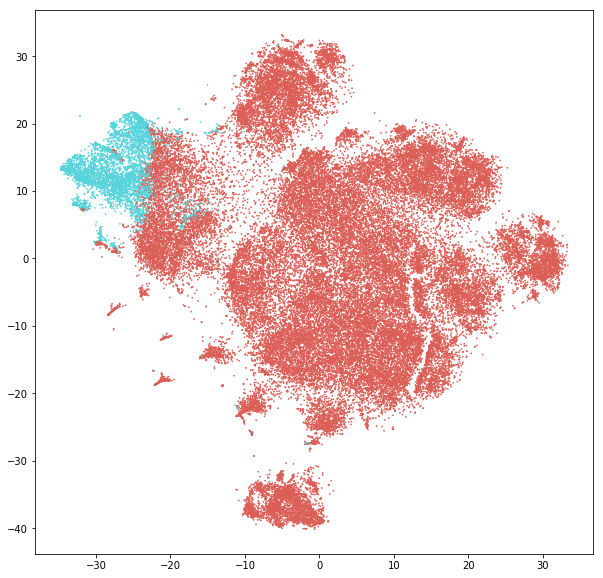

In [152]:
k_labels = labels[0]

num_classes = len(np.unique(k_labels))
palette = np.array(sns.color_palette("hls", num_classes))
plt.figure(figsize = (10,10))
plt.scatter(tsnes[0][:, 0], tsnes[0][:, 1],
            c = palette[k_labels], s = 0.5);

### t-SNE Representation of 3 Clusters

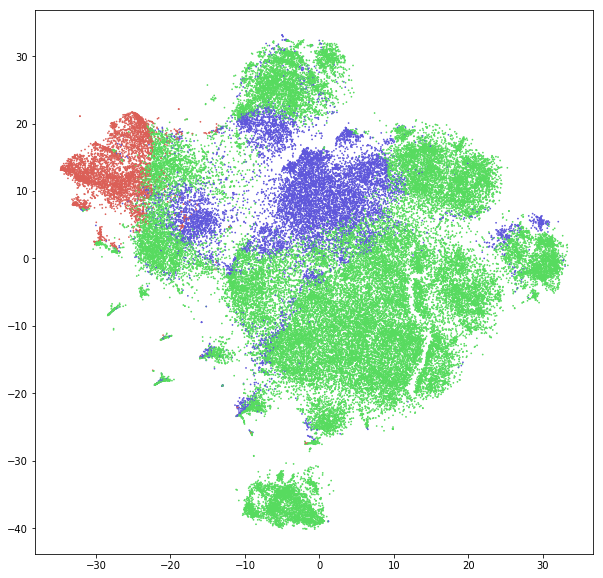

In [165]:
n_clusters = 3
k_labels = labels[n_clusters - 2]

num_classes = len(np.unique(k_labels))
palette = np.array(sns.color_palette("hls", num_classes))
plt.figure(figsize = (10,10))
plt.scatter(tsnes[0][:, 0], tsnes[0][:, 1],
            c = palette[k_labels], s = 0.5);

### t-SNE Representation of 5 Clusters

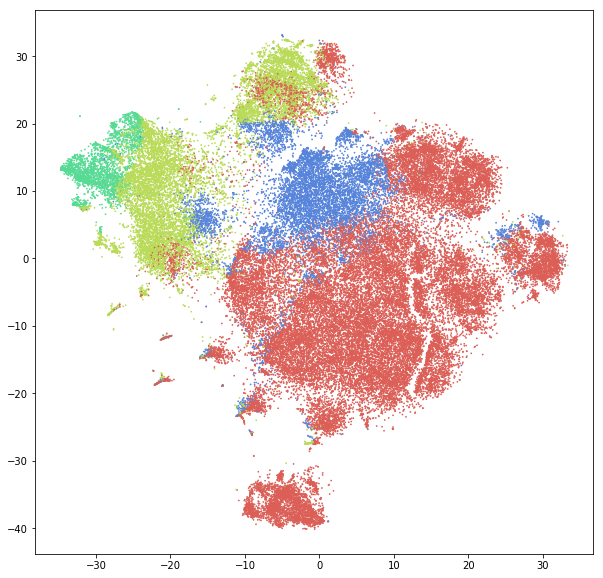

In [166]:
n_clusters = 5
k_labels = labels[n_clusters - 2]

num_classes = len(np.unique(k_labels))
palette = np.array(sns.color_palette("hls", num_classes))
plt.figure(figsize = (10,10))
plt.scatter(tsnes[0][:, 0], tsnes[0][:, 1],
            c = palette[k_labels], s = 0.5);

### t-SNE Representation of 7 Clusters

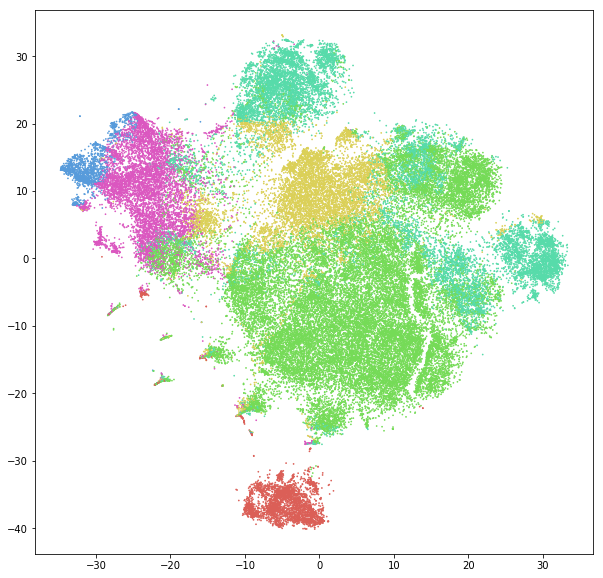

In [167]:
n_clusters = 7
k_labels = labels[n_clusters - 2]

num_classes = len(np.unique(k_labels))
palette = np.array(sns.color_palette("hls", num_classes))
plt.figure(figsize = (10,10))
plt.scatter(tsnes[0][:, 0], tsnes[0][:, 1],
            c = palette[k_labels], s = 0.5);

### t-SNE Representation of 10 Clusters

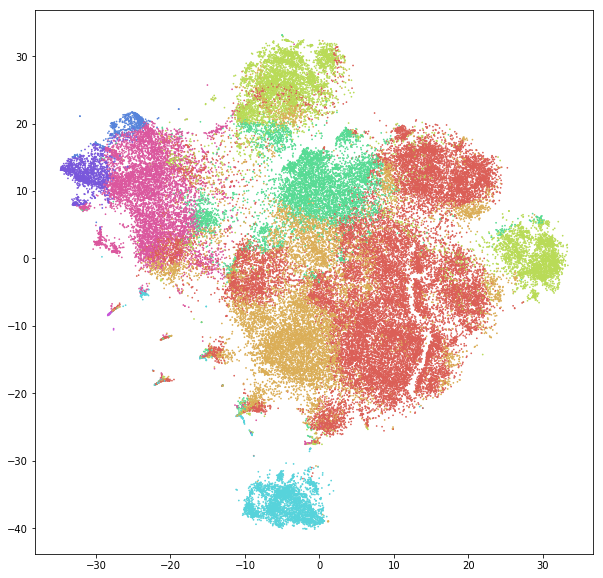

In [168]:
n_clusters = 10
k_labels = labels[n_clusters - 2]

num_classes = len(np.unique(k_labels))
palette = np.array(sns.color_palette("hls", num_classes))
plt.figure(figsize = (10,10))
plt.scatter(tsnes[0][:, 0], tsnes[0][:, 1],
            c = palette[k_labels], s = 0.5);

### t-SNE Representation of 30 Clusters <a class="anchor" id="k_30"></a>

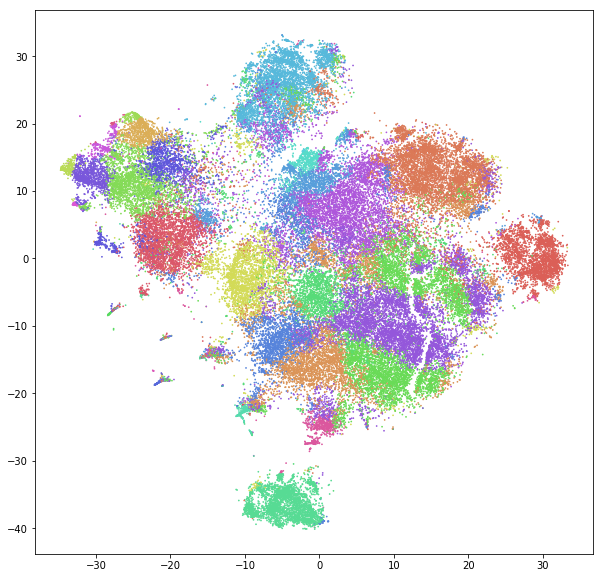

In [196]:
n_clusters = 30
k_labels = labels[n_clusters - 2]

num_classes = len(np.unique(k_labels))
palette = np.array(sns.color_palette("hls", num_classes))
plt.figure(figsize = (10,10))
plt.scatter(tsnes[0][:, 0], tsnes[0][:, 1],
            c = palette[k_labels], s = 0.5);

### t-SNE Representation of 36 Clusters <a class="anchor" id="k_36"></a>

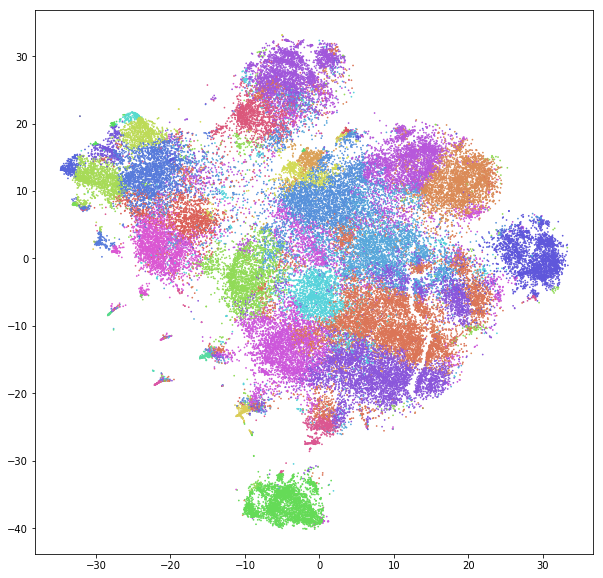

In [181]:
n_clusters = 36
k_labels = labels[n_clusters - 2]

num_classes = len(np.unique(k_labels))
palette = np.array(sns.color_palette("hls", num_classes))
plt.figure(figsize = (10,10))
plt.scatter(tsnes[0][:, 0], tsnes[0][:, 1],
            c = palette[k_labels], s = 0.5);

### t-SNE Representation of 50 Clusters

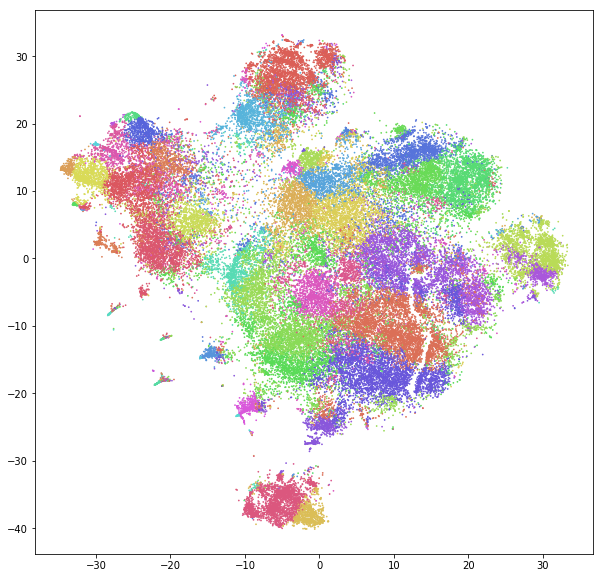

In [170]:
n_clusters = 50
k_labels = labels[n_clusters - 2]

num_classes = len(np.unique(k_labels))
palette = np.array(sns.color_palette("hls", num_classes))
plt.figure(figsize = (10,10))
plt.scatter(tsnes[0][:, 0], tsnes[0][:, 1],
            c = palette[k_labels], s = 0.5);

### t-SNE Representation of 100 Clusters

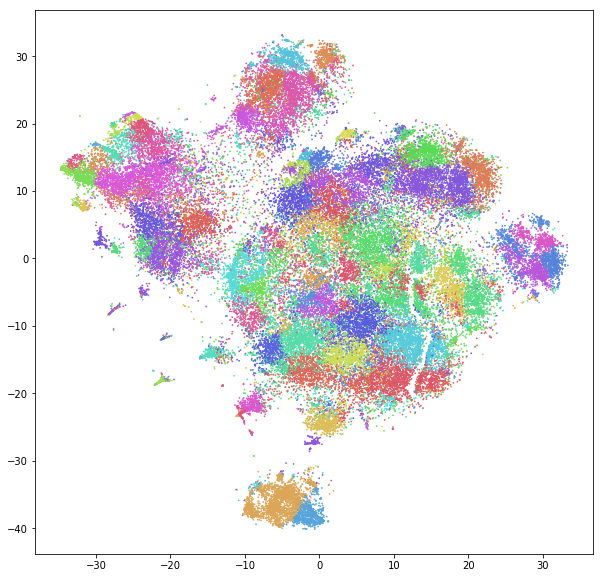

In [171]:
n_clusters = 100
k_labels = labels[n_clusters - 2]

num_classes = len(np.unique(k_labels))
palette = np.array(sns.color_palette("hls", num_classes))
plt.figure(figsize = (10,10))
plt.scatter(tsnes[0][:, 0], tsnes[0][:, 1],
            c = palette[k_labels], s = 0.5);

# References

* Nikolay Oskolkov, [How to tune hyperparameters for t-SNE](https://towardsdatascience.com/how-to-tune-hyperparameters-of-tsne-7c0596a18868)